In [5]:
"""
Approximate CD Driving Solutions for Pyrimethamine (ref: Iram, Dolson, Chiel et al. Nat Phys 2020)

Hinczewski Biotheory Group

@ Shamreen Iram,Michael Hinczewski

"""

from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import interpolate as inp
from scipy import optimize as op
import os, glob2,time

np.seterr(all='raise');

In [6]:
# Specify drive location with all input files needed to run this notebook 
# fitness landscape data+mutation matrix+ABM simulation output files
inputPath="./InputData"

In [7]:
# A: Definitions and Data Files

In [8]:
# A (i): 
# Loading mutation data matrix
# Recasting mutation matrix in required form mm:diagonal entries that make the columns sum zero 

mutdat=np.loadtxt(os.path.join(inputPath,"mut_matrix_.001.dat"),delimiter=',')
mm = np.transpose(mutdat)

for ii in range(mutdat.shape[0]):
    mm[ii,ii]=-(np.sum(mm[ii])-mm[ii,ii])
    
print(mm)

[[-0.001    0.00025  0.00025  0.       0.00025  0.       0.       0.
   0.00025  0.       0.       0.       0.       0.       0.       0.     ]
 [ 0.00025 -0.001    0.       0.00025  0.       0.00025  0.       0.
   0.       0.00025  0.       0.       0.       0.       0.       0.     ]
 [ 0.00025  0.      -0.001    0.00025  0.       0.       0.00025  0.
   0.       0.       0.00025  0.       0.       0.       0.       0.     ]
 [ 0.       0.00025  0.00025 -0.001    0.       0.       0.       0.00025
   0.       0.       0.       0.00025  0.       0.       0.       0.     ]
 [ 0.00025  0.       0.       0.      -0.001    0.00025  0.00025  0.
   0.       0.       0.       0.       0.00025  0.       0.       0.     ]
 [ 0.       0.00025  0.       0.       0.00025 -0.001    0.       0.00025
   0.       0.       0.       0.       0.       0.00025  0.       0.     ]
 [ 0.       0.       0.00025  0.       0.00025  0.      -0.001    0.00025
   0.       0.       0.       0.       0.       0.  

In [9]:
# A (ii): 
# Defining g matrix: takes as input genotype frequency vector xv of length M-1, returns a M-1xM-1 matrix
# M= total no.of genotypes, i-th element xv_i=N_i/N_Tot,i!=WT

def g(xv) :
    x=15; 
    mut=np.zeros((x,x))
               
    for ii in range(x):
        for jj in range(x):
            if ii!=jj:
                mut[ii,jj]=-xv[ii]*xv[jj]
            else:
                mut[ii,jj]=xv[ii]*(1.0 - xv[ii])
    return mut

Text(0, 0.5, 'drug conc cc[t]')

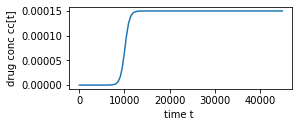

In [10]:
#A (iii): 
# Setting choice of dosage protocol cc(t)

def cc(t) :
    cct=0.00015/(1. + np.exp(-.002*(t - 10000 - 110)))
    return cct
                    
t = np.linspace(0,45000,100)
fig = plt.figure(figsize=(4,1.5))
plt.plot(t,cc(t))
plt.xlabel("time t ")
plt.ylabel("drug conc cc[t]")

In [11]:
# A (iv.i): 
# Defining selection coefficient s(t) using choice of dosage protocol and drug fitness seascape as input

##J: 1+si, si the selection coefficient, is relative fitness of genotpye i compared to WT.
drugless=np.loadtxt(os.path.join(inputPath,"untransformed_drugless_fitnesses.dat"),delimiter=',')
ic50 = np.loadtxt(os.path.join(inputPath,"pyrimethamine_log_IC50s.dat"),delimiter=',')
cs = np.loadtxt(os.path.join(inputPath,"pyrimethamine_cs.dat"),delimiter=',')

#ut is the selection vector s I think (g(x) from Ugbunufor)
def sfc(conc,drugless,ic50,cs) :
    ut=np.zeros(len(cs))
    ut16 = drugless[15]/(1. + np.exp((ic50[15] - np.log10(conc))/cs[15]))
    for i in range(len(cs)):
        try:
            ut[i] = (drugless[i]/(1. + np.exp((ic50[i] - np.log10(conc))/cs[i])))/ut16 -1.
        except FloatingPointError:
            ut[i]=100000. 
        
    return ut

In [12]:
conc = np.arange(1, 1000, 1)
plt.plot(conc, sfc(conc = conc, drugless = drugless, ic50=ic50, cs = cs))

ValueError: setting an array element with a sequence.

In [8]:
# A (iv.ii):  
# Exporting s(t) in input form needed for simulations s-> - s/(1+s)

ssim=[]
for i in range(0,45000):
    si=sfc(cc(i),drugless,ic50,cs)
    for j in range(16):
        try:
            si[j] = -si[j]/(1.+si[j])
        except FloatingPointError:
            si[j]=1.e7 
    ssim.append(si)

ssim.append(si)

##J: need to figure out why s(t) needs to be in this form for simulations

In [9]:
ssim=np.asarray(ssim) 
np.savetxt("sPyr.csv", ssim, delimiter=",")

In [10]:
# A (v): 
# st=table of selection coefficients. Time entries row wise
# dst= st time derivatives
st=[]
for i in range(45001):
    st.append(sfc(cc(i),drugless,ic50,cs))
st=np.asarray(st) 
dst=np.diff(st, axis = 0)



In [11]:
# A (vi): 
# Interpolating s(t) and ds(t)
# si[t,i]: Interpolation function for st[t,i]. t=time,i=genotype 
# dsi[t,i]: Interpolation function for dst[t,i]

si=[];dsi=[]
t = np.arange(0, 45001)
for i in range(16):
    ysi=st[:,i] 
    ydsi=dst[:,i]
    tck_si = inp.splrep(t, ysi,k=3,s=0) 
    tck_dsi = inp.splrep(t[1:,], ydsi,k=3,s=0) 
    ysin = inp.splev(t, tck_si, der=0)
    ydsin = inp.splev(t[1:,], tck_dsi, der=0)#
    si.append(ysin)
    dsi.append(ydsin)

si=np.transpose(np.asarray(si)) #putting time row wise
dsi=np.transpose(np.asarray(dsi))

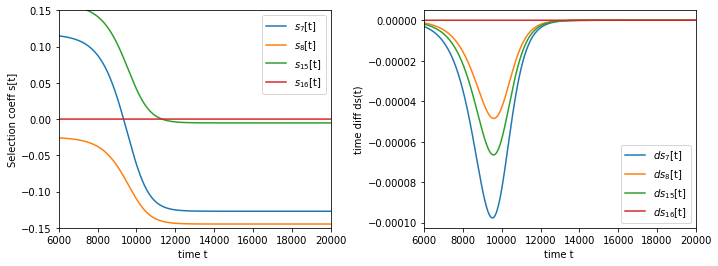

In [12]:
t = np.linspace(0,45000,45001)
dt =t[1:,]
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(t,si[:,6],t,si[:,7],t,si[:,14],t,si[:,15])
ax1.set_ylim([-0.15,0.15])
ax1.set_xlim([6000,20000])
ax1.set_xlabel("time t ")
ax1.set_ylabel("Selection coeff s[t]")
ax1.legend((r"$s_7$[t]","$s_8$[t]","$s_{15}$[t]","$s_{16}$[t]"))
ax2.plot(dt,dsi[:,6],dt,dsi[:,7],dt,dsi[:,14],dt,dsi[:,15])
ax2.set_xlim([6000,20000])
ax2.set_xlabel("time t ")
ax2.set_ylabel("time diff ds(t)")
ax2.legend((r"$ds_7$[t]","$ds_8$[t]","$ds_{15}$[t]","$ds_{16}$[t]"))
ratio = 0.8
for ax in [ax1,ax2]:
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.set_aspect(abs((xmax-xmin)/(ymax-ymin))*ratio, adjustable='box')

In [13]:
#B Time evolution of IE genotype frequencies 

In [79]:
# B (i): 
# xeq0: Guess for mean genotype frequencies Xeq[t] at t0.  Needs to be somewhere in the vicinity of the 
# true answer as evident from s[t]. For Pyrimethamine: we know that genotype 15 dominates at t=0. So a choice of 
# x_16~<1 and small values for the others is a reasonable choice. 
xeq0=np.zeros(len(cs))
for i in range(len(cs)):
    if i==14:
        xeq0[i]=0.96
    else:
        xeq0[i]=0.04/15.0
        
xeq0=[2.6640520000728006e-7, 8.497937098628766e-10, 0.000011228543243808807, 5.133871926146351e-9, 0.000029571363308602964, 1.8988083257640058e-7, 0.0058356945140893976, 0.000010010404687951726, 3.68122355748157e-6, 1.4583229494881715e-8, 0.0021527588695892806, 2.5721408139193052e-6, 0.0017462699991873697, 6.1449379561017145e-6, 0.9886524419593623, 0.0015491491912760225]

xeq0 = np.asarray(xeq0)
print(xeq0)

[2.66405200e-07 8.49793710e-10 1.12285432e-05 5.13387193e-09
 2.95713633e-05 1.89880833e-07 5.83569451e-03 1.00104047e-05
 3.68122356e-06 1.45832295e-08 2.15275887e-03 2.57214081e-06
 1.74627000e-03 6.14493796e-06 9.88652442e-01 1.54914919e-03]


In [80]:
# B (ii.i):
# Solving Eq. S39 from SI: Time evolution of mean IE genotype freq vector Xeq[t,i],i=genotype
# losseq: Takes as input time step and initial guess for Xeq[t] and returns loss func ~ R.H.S of Eq.S39  to
# solve for approximate Xeq[t,i]

def losseq(xg):  
    sM=np.diag(sv) 
    DM=np.identity(16)
    x = np.append(xg, 1.0-np.sum(xg))
    sv15 = sv[0:15] # Leaving out last element for dimensional compatibility
    T1 = np.dot(np.dot(mm,(DM+sM)),x)[0:15]
    T2 = np.dot(g(xg),sv15)
    return (T1 + T2)

In [81]:
# B (ii.ii):
# Solving Eq. S39 from SI: Time evolution of mean IE genotype freq vector Xeq[t,i],i=genotype
# Constructing numeric time series solutions for Xeq[t,i] using a root solver on losseq for t=0,20000
# By t= 20000 the Xeq[t,i] have converged to their final equilibrium values. So augmenting Xeq[t,i] from t=20000
# to t=45000 by appending Xeq[20000,i] many times.

t = np.arange(0, 45002, 1)

Xeq=[]
xg=xeq0[0:15]
print(xg)
for t in range(0,45001,10):
    if t<=20000:
        sv = si[t]
        Xt = op.fsolve(losseq,xg)
        Xt=np.append(Xt,1.-np.sum(Xt))
        Xeq.append(Xt)
        xg=Xt[0:15]
    else:
        Xeq.append(Xeq[2000])        
Xeq=np.asarray(Xeq)



[2.66405200e-07 8.49793710e-10 1.12285432e-05 5.13387193e-09
 2.95713633e-05 1.89880833e-07 5.83569451e-03 1.00104047e-05
 3.68122356e-06 1.45832295e-08 2.15275887e-03 2.57214081e-06
 1.74627000e-03 6.14493796e-06 9.88652442e-01]


In [82]:
print(Xeq)

[[3.54251807e-07 1.23206887e-09 1.42940512e-05 ... 7.19464061e-06
  9.86846907e-01 1.79481980e-03]
 [3.54236335e-07 1.23202058e-09 1.42940460e-05 ... 7.19459933e-06
  9.86846917e-01 1.79481990e-03]
 [3.54220666e-07 1.23197167e-09 1.42940407e-05 ... 7.19455752e-06
  9.86846927e-01 1.79482001e-03]
 ...
 [7.24396217e-12 1.03469238e-11 5.12317982e-08 ... 2.64939358e-04
  4.50350855e-02 9.52583783e-01]
 [7.24396217e-12 1.03469238e-11 5.12317982e-08 ... 2.64939358e-04
  4.50350855e-02 9.52583783e-01]
 [7.24396217e-12 1.03469238e-11 5.12317982e-08 ... 2.64939358e-04
  4.50350855e-02 9.52583783e-01]]


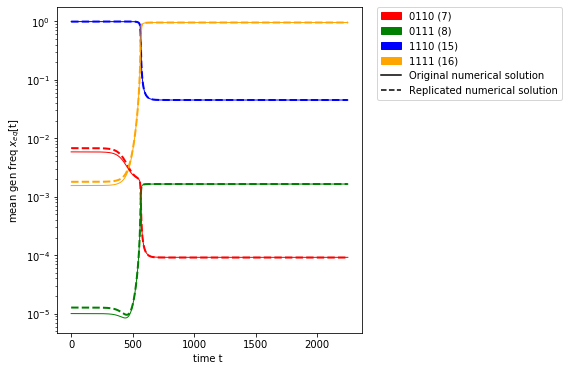

In [117]:
# B (ii.iii):
# Solving Eq. S39 from SI: Time evolution of mean IE genotype freq vector Xeq[t,i],i=genotype
# solution

xeq_Iram =np.array(np.loadtxt("../Evolution-Counterdiabatic-Driving-1.0/analysis/data/xeqi.txt",delimiter='\t'))

t = np.linspace(0,45000,4501)
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
ax1.plot(.05*t, Xeq[0:45000,6], color = "red", linestyle = "--", lw=2)
ax1.plot(.05*t, Xeq[0:45000,7], color = "green", linestyle = "--", lw=2)
ax1.plot(.05*t, Xeq[0:45000,14], color = "blue", linestyle = "--", lw =2)
ax1.plot(.05*t, Xeq[0:45000,15], color = "orange", linestyle = "--", lw =2)

ax1.plot([.05*e[0] for e in xeq_Iram],[e[15] for e in xeq_Iram],lw=1, color = "blue")
ax1.plot([.05*e[0] for e in xeq_Iram],[e[16] for e in xeq_Iram],lw=1, color = "orange")
ax1.plot([.05*e[0] for e in xeq_Iram],[e[7] for e in xeq_Iram],lw=1, color = "red")
ax1.plot([.05*e[0] for e in xeq_Iram],[e[8] for e in xeq_Iram],lw=1, color = "green")

#ax1.set_xlim=[0.05*1000.0,0.05*45000.0]
#ax1.set_ylim=[1e-6,2.0]
#ax1.set_xticks=(np.arange(0.05*10000,0.05*45000,0.05*10000))

plt.yscale("log")
plt.xlabel("time t ")
plt.ylabel(r"mean gen freq $x_{eq}$[t]")
plt.legend((r"$x_{eq7}$[t] (0110)","$x_{eq8}$[t] (0111)","$x_{eq15}$[t] (1110)","$x_{eq16}$[t] (1111)"))
plt.savefig("Comparing4digitToGenotypeNumber.png")

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

red_patch = mpatches.Patch(color='red', label='0110 (7)')
green_patch = mpatches.Patch(color='green', label = "0111 (8)")
blue_patch = mpatches.Patch(color='blue', label = "1110 (15)")
orange_patch = mpatches.Patch(color="orange", label = "1111 (16)")

solid_line = mlines.Line2D([], [], color='black', linestyle="-", label='Original numerical solution')
dashed_line = mlines.Line2D([], [], color='black', linestyle = "--", label='Replicated numerical solution')

plt.legend(handles=[red_patch, green_patch, blue_patch, orange_patch, solid_line, dashed_line], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.savefig("compareNumericalSolutions.png")

In [109]:
for i in range(0, 4500)
print(xeq_Iram[1000, 1:16]-Xeq[1000, 0:15])
               

[ 2.63871531e-07  8.43475031e-10  9.54844854e-06  1.65531659e-09
  2.88638094e-05  1.85587764e-07  3.35270789e-03 -4.12102216e-06
  3.49611481e-06  1.42399832e-08  1.28129910e-03  5.40384615e-08
  1.46660431e-03  4.39729604e-06 -1.45394603e-03]


Text(0.5, 1.0, '$x_{eq}$[t] vs x[t]: K=5e6')

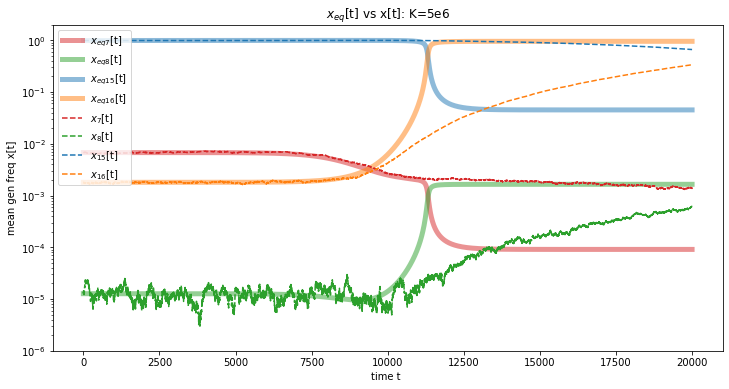

In [65]:
# B (iii):
# Visualizing lag between IE trajectory Xeq[t,i] and actual X[t,i] 
# X[t,i] = output from ABM simulations run with input ssim (from #A (iv.ii))

xSim=np.loadtxt(os.path.join(inputPath,"pop_propsPyr_5M.csv"),delimiter=',',skiprows=1)

x16sim=np.empty(20000)
for i in range(20000):
    x16sim[i]=1.-np.sum(xSim[i,1:16])
    t = np.linspace(0,20000,2000)
    
tSim = np.linspace(0,20000,20000)
fig = plt.figure(figsize=(12,6))
plt.plot(t,Xeq[0:2000,6],'#d62728',t,Xeq[0:2000,7],'#2ca02c',t,Xeq[0:2000,14],'#1f77b4',t,Xeq[0:2000,15],'#ff7f0e',alpha=0.5,lw=5)
plt.plot(tSim,xSim[0:20000,7],'#d62728',tSim,xSim[0:20000,8],'#2ca02c',tSim,xSim[0:20000,15],'#1f77b4',tSim,x16sim[0:20000],'#ff7f0e',alpha=1,ls='dashed')
plt.yscale("log")
plt.xlabel("time t ")
plt.ylim([1e-6,2])
plt.ylabel("mean gen freq x[t]")
plt.legend((r"$x_{eq7}$[t]","$x_{eq8}$[t]","$x_{eq15}$[t]","$x_{eq16}$[t]","$x_{7}$[t]","$x_{8}$[t]","$x_{15}$[t]","$x_{16}$[t]"),loc="upper left")
plt.title(r"$x_{eq}$[t] vs x[t]: K=5e6")

In [19]:
#C Time evolution under CD driving

In [20]:
# C (i):
# Constructing interpolation functions for Xeq[t,i] and time derivative of mean genotype frequencies dXeq[t,i].
# dXeq[t,i]= time derivative of Xeq[t,i] needed for calculating s_CD[t]
# Xeqi[t,i]: Interpolation function for Xeq[t,i] 
# dXeqi[t,i]: Interpolation function for dXeq[t,i]

dXeq=np.diff(Xeq, axis = 0)/10 

Xeqi=[];dXeqi=[]
t = np.arange(0, 45001,10)
for i in range(16):
    yXeqi=Xeq[:,i] 
    ydXeqi=dXeq[:,i]
    tck_Xeqi = inp.splrep(t, yXeqi,k=3,s=0) 
    tck_dXeqi = inp.splrep(t[1:], ydXeqi,k=3,s=0) 
    yXeqin = inp.splev(t, tck_Xeqi, der=0)
    ydXeqin = inp.splev(t[1:], tck_dXeqi, der=0)#
    Xeqi.append(yXeqin)
    dXeqi.append(ydXeqin)

Xeqi=np.transpose(np.asarray(Xeqi))
dXeqi=np.transpose(np.asarray(dXeqi))

In [31]:
# C (ii):
# Evaluating scd[t,i]= perturbation to take s(t)-> s_CD(t) (second term on R.H.S of Eq.4 of manuscript)


d=0.05 #ABM death rate, needed for ABM sim-WF mapping

scdt=[]; scdp=np.empty([4500,16])
for t in range(0,4500):
    scdi=np.zeros(16)
    for i in range(0,15):
        T1=(1.-np.sum(np.delete(Xeq[t,0:15],i)))*dXeq[t,i]
        T2=(np.sum(np.delete(dXeq[t,0:15],i)))*Xeq[t,i]
        T3=Xeq[t,i]*(1.-np.sum(Xeq[t,0:15]))
        scdi[i]=(1./d)*(T1+T2)/T3
        scdi[15]=0. #adding zero for wild type 
    scdt.append(scdi)
    
scdt=np.asarray(scdt)

In [32]:
# C (iii):
# Calculating selection coefficient CD protocol s_tilde(t)= scdp[t,i]
# scdi[t,i]=interpolation function for scdt[t,i]
# scdp[t,i] =[original s protocol + perturbation]= si[t,i]+scdi[t,i]
# Setting the most unfit genotypes to be -0.99 instead of -1 to prevent numerical issues. 


scdi=[];scdp=np.empty([45000,16]); ts = np.arange(0, 45000,10);t= np.arange(0, 45000)#dt=t[1:,]

for i in range(0,16):
    yscdi=scdt[:,i]
    tck_scdi = inp.splrep(ts, yscdi,k=3,s=0) 
    yscdin = inp.splev(t, tck_scdi, der=0)
    scdi.append(yscdin)
    
scdi=np.transpose(np.asarray(scdi))
for t in range(0,45000):
    scdp[t]=si[t]+scdi[t]
    for i in range(0,len(scdp[t])):
        scdp[t,i]=max(scdp[t,i], -0.99)

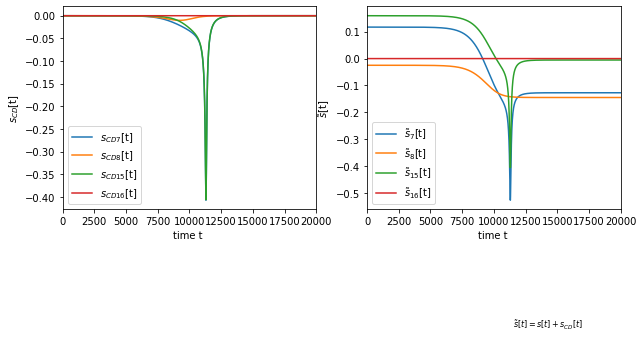

In [33]:
t = np.linspace(0,20000,20000)
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(t,scdi[0:20000,6],t,scdi[0:20000,7],t,scdi[0:20000,14],t,scdi[0:20000,15])
ax1.set_xlim([0,20000])
ax1.set_xlabel("time t ")
ax1.set_ylabel(r"$s_{CD}$[t]")
ax1.legend((r"$s_{CD7}$[t]","$s_{CD8}$[t]","$s_{CD15}$[t]","$s_{CD16}$[t]"))
ax2.plot(t,scdp[0:20000,6],t,scdp[0:20000,7],t,scdp[0:20000,14],t,scdp[0:20000,15])
ax2.set_xlim([0,20000])
ax2.set_xlabel("time t ")
ax2.set_ylabel(r"$\tilde{s}$[t]")
ax2.legend((r"$\tilde{s}_7$[t]",r"$\tilde{s}_8$[t]",r"$\tilde{s}_{15}$[t]",r"$\tilde{s}_{16}$[t]"))
ax2.text(11500,-1,r"$\tilde{s}[t]=s[t]+s_{CD}[t]$",fontsize=8)
ratio = 0.8
for ax in [ax1,ax2]:
   xmin, xmax = ax.get_xlim()
   ymin, ymax = ax.get_ylim()
   ax.set_aspect(abs((xmax-xmin)/(ymax-ymin))*ratio, adjustable='box')

In [34]:
# C (iv):
# Estimating the approximate CD drug protocol ccv 
# Process: Find drug conc perturbation dcc= ccv -cc that minimizes  fminCD(conc) 
# fminCD(conc)= the R.H.S of Eq.S60.  


def fminCD(ccv): #input array: ccv[0]=t ccv[1]=ccv (CD drug perturbation)
    T1=((1./d)*dXeqi[i,0:15])
    T2=np.dot(g(Xeqi[i,0:15]),(sfc(ccv,drugless,ic50,cs)-si[t])[:15])
    return np.log10(np.sum(pow((T1-T2),2.)))

dcc=[];ccvg=np.empty(4500)
t=0;i = 0 #first value 
ccvg[0] = abs(op.fmin(fminCD,cc(0)+1e-15,disp=False))
dcc.append(ccvg[0]-cc(0))
for i in range(1,4500):
    t=i*10
    ccvg[i]=abs(op.fmin(fminCD,cc(t)+1.e-15,disp=False))
    dcc.append(ccvg[i]-cc(t))#guess value for ccv=cc +very small perturbation~10^-15
    
dcc=np.asarray(dcc)

In [35]:
# C (v): 
# Final CD drug conc protocol ccv=cc+dcc
# ccCD= interpolation ccv
# Realistic protocol: setting bound maxc on drug conc value (cannot kill patient!!)


ccv=np.empty([4500]); maxc = 0.01
for i in range(0,4500):
    t=i*10.
    ccv[i]=min(maxc,dcc[i]+cc(t))
ts = np.arange(0, 45000,10);t= np.arange(0, 45000)    
tck_ccvi = inp.splrep(ts,ccv,k=3,s=0) 
ccCD = inp.splev(t, tck_ccvi, der=0)

Text(0, 0.5, 'Drug conc')

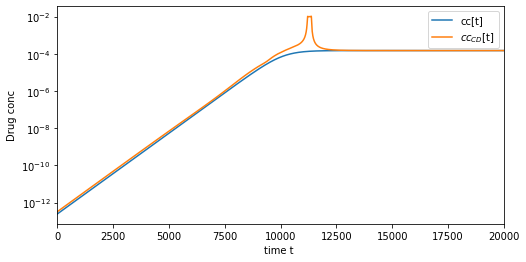

In [36]:
ts = np.arange(0,45000)
tM = np.arange(0,20000)
fig = plt.figure(figsize=(8,4))
plt.plot(ts,cc(ts),ts,ccCD)
plt.yscale("log")
plt.xlim(0,20000)
plt.legend((r"cc[t]",r"$cc_{CD}$[t]"))
plt.xlabel("time t ")
plt.ylabel(r"Drug conc")

In [37]:
# C (vi):
# Exporting CD sel coeff protocol in form needed for ABM code: s --> -s/1+s
sCDsim=[]
for i in range(0,45000):
    sCD=sfc(ccCD[i],drugless,ic50,cs)
    for j in range(16):
        try:
            sCD[j] = -sCD[j]/(1.+sCD[j])
        except FloatingPointError:
            sCD[j]=1.e7 
    sCDsim.append(sCD)

sCDsim.append(sCD)

In [28]:
sCDsim=np.asarray(sCDsim) 
np.savetxt("sCDPyr.csv", sCDsim, delimiter=",")

Text(0.5, 1.0, '$x_{eq}$[t] vs $x_{CD}$[t]: K=5e6')

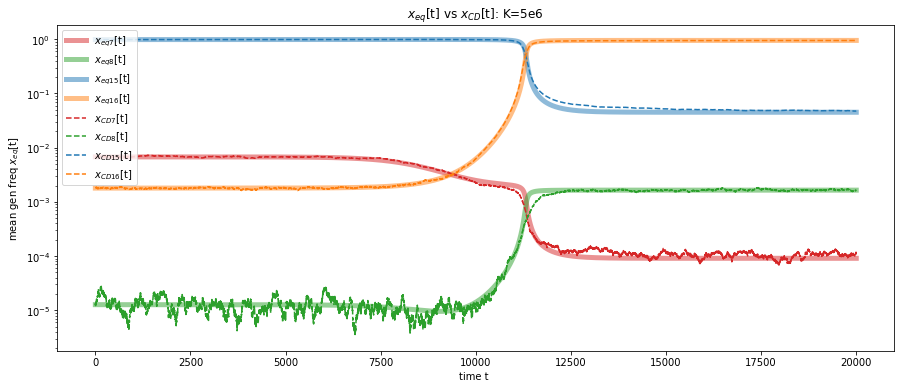

In [32]:
# C (vii):
# Visualizing IE trajectory Xeq[t,i] against CD driven actual X_CD[t,i] 
# X_CD[t,i] = output from ABM simulations run with input sCDsim (from #C (vi))

xSim=np.loadtxt(os.path.join(inputPath,"pop_propsPyrCD_5M.csv"),delimiter=',',skiprows=1)

x16sim=np.empty(20000)
for i in range(20000):
    x16sim[i]=1.-np.sum(xSim[i,1:16])
    t = np.linspace(0,20000,2000)
    
t = np.linspace(0,20000,2000);tSim = np.linspace(0,20000,20000)
fig = plt.figure(figsize=(15,6))
plt.plot(t,Xeq[0:2000,6],'#d62728',t,Xeq[0:2000,7],'#2ca02c',t,Xeq[0:2000,14],'#1f77b4',t,Xeq[0:2000,15],'#ff7f0e',alpha=0.5,lw=5)
plt.plot(tSim,xSim[0:20000,7],'#d62728',tSim,xSim[0:20000,8],'#2ca02c',tSim,xSim[0:20000,15],'#1f77b4',tSim,x16sim[0:20000],'#ff7f0e',linestyle='dashed')
plt.yscale("log")
plt.xlabel("time t ")
plt.ylabel(r"mean gen freq $x_{eq}$[t]")
plt.legend((r"$x_{eq7}$[t]","$x_{eq8}$[t]","$x_{eq15}$[t]","$x_{eq16}$[t]","$x_{CD7}$[t]","$x_{CD8}$[t]","$x_{CD15}$[t]","$x_{CD16}$[t]"),loc="upper left")
plt.title(r"$x_{eq}$[t] vs $x_{CD}$[t]: K=5e6")